In [1]:
%matplotlib inline

In [2]:
# import all necessary libraries

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi

from dv import AedatFile
import cv2
from time import sleep

from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel


### Gabor filter banks for texture classification

In this example, we will see how to classify textures based on Gabor filter
banks. Frequency and orientation representations of the Gabor filter are
similar to those of the human visual system.

The images are filtered using the real parts of various different Gabor filter
kernels. The mean and variance of the filtered images are then used as features
for classification, which is based on the least squared error for simplicity.


Rotated images matched against references using Gabor filter banks:
original: brick, rotated: 30deg, match result: brick
original: brick, rotated: 70deg, match result: brick
original: grass, rotated: 145deg, match result: brick


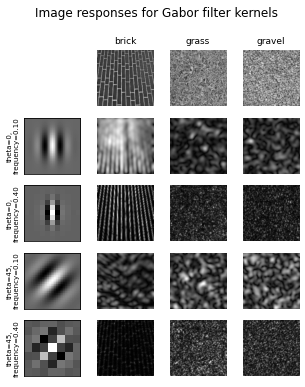

In [3]:
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats


def match(feats, ref_feats):
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        if error < min_error:
            min_error = error
            min_i = i
    return min_i


# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)


shrink = (slice(0, None, 3), slice(0, None, 3))
brick = img_as_float(data.brick())[shrink]
grass = img_as_float(data.grass())[shrink]
gravel = img_as_float(data.gravel())[shrink]
image_names = ('brick', 'grass', 'gravel')
images = (brick, grass, gravel)

# prepare reference features
ref_feats = np.zeros((3, len(kernels), 2), dtype=np.double)
ref_feats[0, :, :] = compute_feats(brick, kernels)
ref_feats[1, :, :] = compute_feats(grass, kernels)
ref_feats[2, :, :] = compute_feats(gravel, kernels)

print('Rotated images matched against references using Gabor filter banks:')

print('original: brick, rotated: 30deg, match result: ', end='')
feats = compute_feats(ndi.rotate(brick, angle=190, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])

print('original: brick, rotated: 70deg, match result: ', end='')
feats = compute_feats(ndi.rotate(brick, angle=70, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])

print('original: grass, rotated: 145deg, match result: ', end='')
feats = compute_feats(ndi.rotate(grass, angle=145, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])


def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
for theta in (0, 1):
    theta = theta / 4. * np.pi
    for frequency in (0.1, 0.4):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append((kernel, [power(img, kernel) for img in images]))

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(5, 6))
plt.gray()

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

axes[0][0].axis('off')

# Plot original images
for label, img, ax in zip(image_names, images, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=9)
    ax.axis('off')

for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel))
    ax.set_ylabel(label, fontsize=7)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    vmin = np.min(powers)
    vmax = np.max(powers)
    for patch, ax in zip(powers, ax_row[1:]):
        ax.imshow(patch, vmin=vmin, vmax=vmax)
        ax.axis('off')

plt.show()

In [4]:
with AedatFile("./data/fork.aedat4") as f:
    # list all the names of streams in the file
    print(f.names)

    # Access dimensions of the event stream
    height, width = f['events'].size

    # # loop through the "events" stream
    # for e in f['events']:
    #     print(e.timestamp)

    # loop through the "frames" stream
    # for frame in f['frames']:
    #     #print(frame.timestamp)
    #     plt.imshow(frame.image)
    #     sleep(0.05)


['events', 'frames', 'imu', 'triggers']


### Import as numpy file

In [7]:
with AedatFile("./data/fork.aedat4") as f:
    # events will be a named numpy array
    events = np.hstack([packet for packet in f['events'].numpy()])

    # Access information of all events by type
    t, x, y, p = events['timestamp'], events['x'], events['y'], events['polarity']
    # Access individual events information
    event_123_x = events[123]['x']
    # Slice events
    first_100_events = events[:100]

In [9]:
from numpy import genfromtxt 

x, y = genfromtxt('./data/sim/x.csv', delimiter=','), genfromtxt('./data/sim/y.csv', delimiter=',')
t, p = genfromtxt('./data/sim/t.csv', delimiter=','), genfromtxt('./data/sim/p.csv', delimiter=',')

# Combine into tuple 
event_tuple = list(zip(x,y,t,p))

events = np.array(event_tuple,dtype=[('x', '<i8'), ('y', '<i8'), ('t', '<i8'), ('p', '<i8')])

In [10]:
events['x'], events['y'], events['p'], events['t']

(array([272, 276, 257, ..., 269, 278, 260], dtype=int64),
 array([175, 189, 139, ..., 175, 194, 147], dtype=int64),
 array([0, 1, 0, ..., 1, 1, 0], dtype=int64),
 array([  1001145,   1001227,   1004782, ..., 857998587, 857998903,
        857999907], dtype=int64))

In [11]:
print(np.max(events['p']), np.min(events['p']))

1 0


### plot 3d (turn into function)

In [17]:
np.min(polarity)

0.0

<ipython-input-14-a51eba364960>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


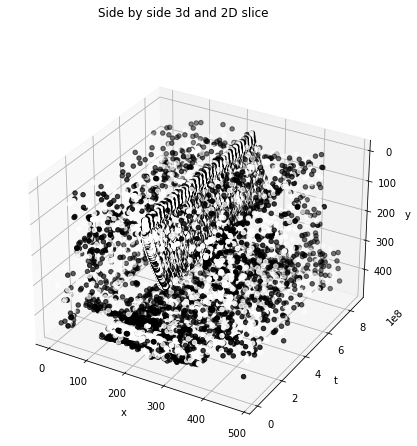

In [14]:
fig = plt.figure(figsize=(14,7))
fig.suptitle('Side by side 3d and 2D slice ')
ax = fig.add_subplot(111, projection='3d') 

# Data for three-dimensional scattered points
zdata = y
xdata = x
ydata = t
polarity = p
ax.scatter3D(xdata, ydata, zdata, c=polarity)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('y')
ax.invert_zaxis()

#2d time surface slice 
#ax = fig.add_subplot(212)
fig.show()

### Convert to Frame/Time surface

In [22]:
import tonic.transforms as transforms

frame_transform = transforms.ToFrame(sensor_size=(int(events["x"].max() + 1),int(events["y"].max() + 1),2), time_window=500000)
frames = frame_transform(events) # numpy array with dimensions (TxPxHxW)
print("Data dimensions", np.shape(frames))
print(np.shape(frames[0]))

Data dimensions (1713, 2, 466, 480)
(2, 466, 480)


Exception ignored in: <function AedatFile.__del__ at 0x00000201866B8040>
Traceback (most recent call last):
  File "E:\Software\Anaconda\lib\site-packages\dv\AedatFile.py", line 215, in __del__
    self.close()
  File "E:\Software\Anaconda\lib\site-packages\dv\AedatFile.py", line 218, in close
    self._file.close()
AttributeError: 'AedatFile' object has no attribute '_file'


In [101]:
from skimage.filters import gabor
from skimage import data, io
from matplotlib import pyplot as p

data = frames[0][1] # data.coins()

io.imshow(image)
# detecting edges in a coin image
filt_real, filt_imag = gabor(image, frequency=0.6, bandwidth=0.5)
plt.figure()        
io.imshow(filt_real)
io.show()           

# less sensitivity to finer details with the lower frequency kernel
filt_real, filt_imag = gabor(image, frequency=0.1)
plt.figure()        
io.imshow(filt_real)
io.show()           


E:\Software\Anaconda\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


In [102]:
### Apply Gabor filter frame by frame
gabor_filtered = []

def normalize(data): 
    image = ((data - data.min()) * (1/(data.max() - data.min()) * 255)).astype('uint8') # First normalize to 0-255
    return image

for i in range(len(frames)):    
    x, _ = gabor(normalize(frames[i][0]), frequency = 0.6, bandwidth= 0.5) # take only the real part! 
    gabor_filtered.append(x)

print("before", np.shape(gabor_filtered))
np.stack(gabor_filtered)
np.shape(gabor_filtered)

gabor_filtered = np.asarray(gabor_filtered)
print("After", np.shape(gabor_filtered))

before (1713, 466, 480)
After (1713, 466, 480)


In [86]:
%matplotlib tk
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

print(np.shape(frames))
f, [[ax1, ax2],[ax3, ax4]] = plt.subplots(2,2, figsize=(12,12))


ax1.set_ylabel('y')
ax1.set_xlabel('x')

ax2.set_ylabel('Magnitude')
ax2.set_xlabel('Time')


def time_surface(time, polarity, x, y ):
    # plot timesurface for specified time
    ax1.imshow(frames[time,polarity,:, :])

    # filtered for specified time
    ax3.imshow(gabor_filtered[time,:, :])

    # plot pixel over time
    ax2.clear()
    ax2.plot(frames[:,polarity,x, y])

    #plot gabor_filtered pixel over time
    ax4.clear()
    ax4.plot(gabor_filtered[:,x, y])

    plt.show()
    return()

# xy = (104,245)


interact(time_surface, polarity =(0,1,1), time= (0, np.shape(frames)[0]-1, 1), x=(0, np.shape(frames[0][0])[0]-1, 1), y=(0, np.shape(frames[0][0])[1]-1, 1) );

(1713, 2, 466, 480)


interactive(children=(IntSlider(value=856, description='time', max=1712), IntSlider(value=0, description='pola…

In [100]:
plt.figure()
#plt.plot(np.abs(np.fft.fft(gabor_filtered[:,102, 244])))

plt.imshow(np.abs(np.fft.fft(gabor_filtered[:,:, 244], axis=0)), cmap='Reds') #0-100 x , y= 245


In [89]:
np.shape(gabor_filtered[:,102, 244])

(1713,)

### Save as image for analysis.

In [12]:
print(np.shape(frames[20][1]))
test_time_surface = frames[20][1]

from PIL import Image 
test_time_surface = (test_time_surface*255).astype(np.uint8)
print(np.max(test_time_surface))

image = Image.fromarray(test_time_surface)
image.save('test_time_surface.png', format="png")

(466, 480)
255


### Try visualizing gabor filters

In [13]:
%matplotlib qt 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


# read img and set gray color
img = cv2.imread('test_time_surface.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# dashboard settings
fig, (ax, ax_2) = plt.subplots(1, 2, figsize=(10,10))
plt.subplots_adjust(left=0.25, bottom=0.45)

# create slider spaces
axcolor = 'lightgoldenrodyellow'
ax_sliders = [plt.axes([0.25, 0.1 + 0.05 * i, 0.65, 0.03], facecolor=axcolor) for i in range(6)]

# define parameter sliders
ksize = Slider(ax_sliders[0], 'ksize', 1, 40, valinit=21, valstep=1)
sigma = Slider(ax_sliders[1], 'sigma', 0.1, 20.0, valinit=8, valstep=0.1)
lambd = Slider(ax_sliders[2], 'lambd', 0.1, 20.0, valinit=10, valstep=0.1)
gamma = Slider(ax_sliders[3], 'gamma', 0.1, 1, valinit=0.5, valstep=0.05)
psi = Slider(ax_sliders[4], 'psi', -10, 10, valinit=0, valstep=1)
theta = Slider(ax_sliders[5], 'theta', -5, 5, valinit=0, valstep=0.1)

sliders = [ksize, sigma, lambd, gamma, psi, theta]


def update(val):
    # on slider update recalculate gabor kernel
    g_kernel = cv2.getGaborKernel(ksize=(ksize.val, ksize.val),
                                  sigma=sigma.val,
                                  theta=np.pi / 4 * theta.val,
                                  lambd=lambd.val,
                                  gamma=gamma.val,
                                  psi=psi.val,
                                  ktype=cv2.CV_32F)
    # recalculate img result
    res = cv2.filter2D(img, cv2.CV_8UC3, g_kernel)

    # show new img and gabor kernel
    ax.imshow(res, interpolation="nearest", cmap='gray')
    ax.set_title('gabor result on img', fontsize=10)
    ax_2.imshow(g_kernel, interpolation="nearest", cmap='gray')
    ax_2.set_title('g_kernel', fontsize=10)


for i in sliders:
    i.on_changed(update)

update(None)

resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    for slider in sliders:
        slider.reset()


button.on_clicked(reset)
plt.show()

%matplotlib inline

In [ ]:
np.shape(frames)

%matplotlib inline 
import matplotlib.pyplot as plt

def plot_frames(frames):
    fig, axes = plt.subplots(1, len(frames), figsize=(20,20))
    for axis, frame in zip(axes, frames):
        print(np.shape(frame))
        axis.imshow(frame[1])
        print(np.max(frame[1]))
        axis.axis("off")
    plt.tight_layout()
        
plot_frames(frames)

In [ ]:
### Now apply gabor filter in each event neighbourhood of 10x10



In [ ]:
sensor_size = tonic.datasets.DAVISDATA.sensor_size
sensor_size

In [ ]:
# turn into 3d numpy array for easy time surface manipulation 

# Combine x and y into indexable spatial coordinate 
event_xy = np.vstack((x,y))
np.shape(event_xy)

# Loop through every element to create time surface.
for polarity in p: 